<h2>11 June 2015 event in PECAN</h2>

<b>Author</b><br>
Nick Guy

<b>Overview</b><br>
On 11 June 2015 during the PECAN field campaign, the UWyo King Air aircraft encountered severe turbulence followed by a large negative G "slap". 


In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pyart
import awot
import pyradarmet
from awot.graph import create_basemap, FlightLevel, RadarHorizontalPlot
%matplotlib inline

Open the NEXRAD files using Py-ART and load the UWKA flight data using AWOT.<br><br>
There were two NEXRAD radars with view of this system - KTWX and KUEX, located in Topeka, KS and Grand Island, NE, respectively. We will load both radar instances, but only use KUEX as this radar was better located with respect to the storm position and was nearer to the UWyo King Air at the time severe turbulence was encountered.<br><br>

A plot of KTWX later does show that an enhanced turbulence signal was observed in this data as well.

In [2]:
fdir = '/Users/guy/data/pecan'
files = glob.glob(os.path.join(fdir, 'cfradial', '*.nc'))
print(files[13])
# KUEX
# We are using AWOT to read the file here, which keeps the original Py-ART instance 
# when `map_to_awot' is set to False
radar2 = awot.io.read_ground_radar(files[13], map_to_awot=False)

/Users/guy/data/pecan/cfradial/KUEX20150611_031925_V06.nc


Read the UWKA flight data file using AWOT, first provide a mapping dictionary as default is slightly different for this file.

In [3]:
name_map = {
#        'time': 'time',
            # Aircraft Position
            'longitude': 'LONC',
            'latitude': 'LATC',
            'altitude': 'ztrue',
            'pressure_altitude': 'PALT',
            'tas': 'tas',
            'ias': 'aias',
            'true_heading': 'AVthead',
            'pitch': 'AVpitch',
            'roll_angle': 'AVroll',
            # Atmospheric State
            'pressure': 'pmb',
            'temperature': 'trf',
            'dewpoint_temperature': 'tdplicor',
            'thetad': 'thetad',
            'thetae': 'thetae',
            'relative_humidity': 'rh',
            'mixing_ratio': 'mr',
            'lwc': 'lwc100',
            'turb': 'turb',
            'g_accel': 'avnorma',
            # Radiometric
            'irtop': 'irtc',
            'irbottom': 'irbc',
            'swtop': 'swt',
            'swbottom': 'swb',
            # Wind derivations
            'Uwind': 'avuwind',
            'Vwind': 'avvwind',
            'Wwind': 'avwwind',
            'longitudinal_wind': 'avux',
            'latitudinal_wind': 'avvy',
            'wind_dir': 'avwdir',
            'wind_spd': 'axwmag',
            # Licor Concentrations
            'co2_conc': 'co21s',
            'h2o_conc': 'h2o1s',
            # Aerosol
            'pcasp_num': 'AS200_OBR',
            'pcasp_conc': 'CS200_OBR',
            'pcasp_mean_diam': 'DBARP_OBR',
            'pcasp_surf_area_conc': 'PSFCP_OBR',
            'pcasp_vol_conc': 'PVOLP_OBR',
            # Cloud Physics
            'conc_cpc': 'cpc_conc',
            # Miscellaneous
            'topo': 'topo'}

flight1Hz = awot.io.read_netcdf(os.path.join(fdir, '20150611.c1.nc'), mapping_dict=name_map)

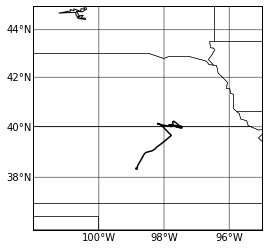

In [5]:
bm = create_basemap(corners=[-102., 36., -95., 45.], proj='cea', resolution='l')
bm.drawstates()
fl = FlightLevel(flight1Hz, basemap=bm)
fl.plot_trackmap()

Set up some plot list functions that produce multipanel plots using Py-ART functions.

In [12]:
def plot_list_of_fields(radar, sweep=0, fields=['reflectivity'], vmins=[0],
                        vmaxs=[65], units=['dBZ'], cmaps=['RdYlBu_r'],
                        return_flag=False, xlim=[-150, 150], ylim=[-150, 150],
                        mask_tuple=None, savefig=False):
    num_fields = len(fields)
    if mask_tuple is None:
        mask_tuple = []
        for i in np.arange(num_fields):
            mask_tuple.append(None)
    nrows = (num_fields + 1) // 2
    ncols = (num_fields + 1) % 2 + 1
    fig = plt.figure(figsize=(14.0, float(nrows)*5.5))
    display = pyart.graph.RadarDisplay(radar)
    for index, field in enumerate(fields):
        ax = fig.add_subplot(nrows, 2, index+1)
        display.plot_ppi(field, sweep=sweep, vmin=vmins[index],
                         vmax=vmaxs[index],
                         colorbar_label=units[index], cmap=cmaps[index],
                         mask_tuple=mask_tuple[index])
        display.set_limits(xlim=xlim, ylim=ylim)
    plt.tight_layout()
    if savefig:
        plt.savefig(display.generate_filename(field, sweep, ext='png'))
    if return_flag:
        return display
    
def plot_list_of_fields_to_map(radar, sweep=0, fields=['reflectivity'], vmins=[0],
                        vmaxs=[65], units=['dBZ'], cmaps=['RdYlBu_r'],
                        return_flag=False, lonlim=[-180, 180], latlim=[-90, 90],
                        projection='lcc', resolution='l',
                        mask_tuple=None, plot_track=False, flight=None,
                        start_time=None, end_time=None,
                        plot_time_stamps=False, timestep=600,
                        savefig=False):
    num_fields = len(fields)
    if mask_tuple is None:
        mask_tuple = []
        for i in np.arange(num_fields):
            mask_tuple.append(None)
    nrows = (num_fields + 1) // 2
    ncols = (num_fields + 1) % 2 + 1
    fig = plt.figure(figsize=(14.0, float(nrows)*5.5))
    mapdisplay = pyart.graph.RadarMapDisplay(radar)
    for index, field in enumerate(fields):
        ax = fig.add_subplot(nrows, 2, index+1)
        mapdisplay.plot_ppi_map(field, sweep, vmin=vmins[index], vmax=vmaxs[index],
                     min_lon=lonlim[0], max_lon=lonlim[1], 
                     min_lat=latlim[0], max_lat=latlim[1],
                     cmap=cmaps[index],
                     projection=projection, resolution=resolution,
                     lat_0=radar.latitude['data'][0],
                     lon_0=radar.longitude['data'][0])
        if plot_track:
            f2 = FlightLevel(flight, basemap=mapdisplay.basemap)
            f2.plot_trackmap(min_altitude=50., lw=2.5,
                            start_time=start_time, end_time=end_time)
        if plot_time_stamps:
            f2.time_stamps(start_time=start_time, end_time=end_time,
                           labelspacing=timestep)
    plt.tight_layout()
    if savefig:
        plt.savefig(mapdisplay.generate_filename(field, sweep, ext='png'))
    if return_flag:
        return mapdisplay

First let's take a look at the overall system structure and plot out reflectivity and spectrum width. The morphology may be considered to be a quasi-linear MCS. This particular syatem had "fingers" extending to the South-Southeast, where vigorous convection was initiating. The system was extremely electrically active. In lower panels where the aircraft track is plotted, the most electrically active area was N-NE of the aircraft.<br>
From the view of the Reflectivity base scan there was no indication of the turbulence that awaited...The spectrum width tells a differet story potentially.

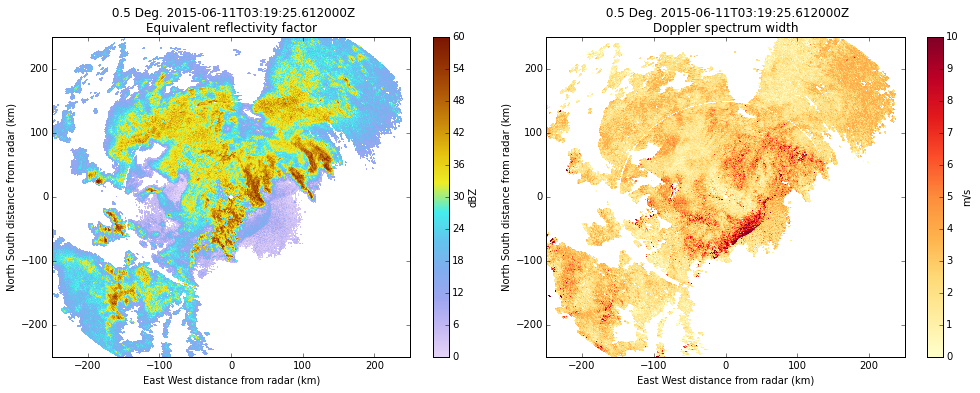

In [14]:
plot_list_of_fields(radar2, sweep=1, xlim=[-250, 250], ylim=[-250, 250],
                    fields=['reflectivity', 'spectrum_width'],
                    vmins=[0, 0], vmaxs=[60, 10], 
                    units=['dBZ', 'm/s'],
                    cmaps=['pyart_LangRainbow12','YlOrRd'],
                    savefig=True)

Let's take a quick look at the flight data leading up the event and plot some time series

In [15]:
flight_subset = ["2015-06-11 03:10:00", "2015-06-11 03:24:00"]

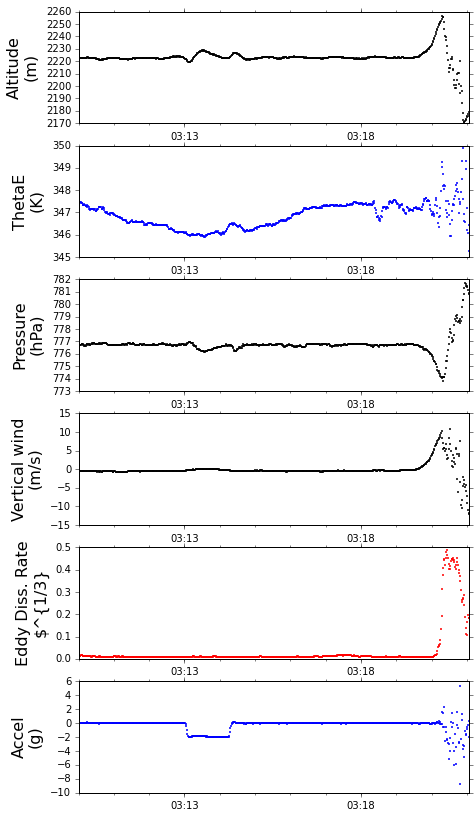

In [17]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(7, 14))
fl = FlightLevel(flight1Hz, basemap=None)
fl.plot_timeseries('altitude', color='k', marker='o', msize=1.5, lw=2,
                    dForm='%H:%M', tz=None, xdate=True,
#                    date_MinTicker='minute', other_MajTicks=None, other_MinTicks=None,
#                    other_min=None, other_max=None, 
                    start_time=flight_subset[0], end_time=flight_subset[1],
                    title=None, ylab='Altitude\n(m)', ax=ax1)

fl.plot_timeseries('thetae', color='b', ylab='ThetaE\n(K)', 
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax2)
fl.plot_timeseries('pressure', color='k', ylab='Pressure\n(hPa)', 
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax3)
fl.plot_timeseries('Wwind', color='k', ylab='Vertical wind\n(m/s)',
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax4)
fl.plot_timeseries('turb', color='r', ylab='Eddy Diss. Rate\n$^{1/3}',
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax5)
fl.plot_timeseries('g_accel', color='b', ylab='Accel\n(g)',
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax6)

Now let's find out the height of our radar beam at various elevation angles in the radar volume using the Haversine formula. From below sweeps 4, 5, and 6 are closest in height. Sweep 4 returns no valid data.

In [21]:
#print(radar2.elevation['data'][radar2.sweep_start_ray_index['data'][:]])
#print(radar2.elevation['data'][radar2.sweep_end_ray_index['data'][:]])

lat1, lon1 = radar2.latitude['data'][0], radar2.longitude['data'][0]
lat2, lon2 = flight1Hz['latitude'][-1], flight1Hz['longitude'][-1]
delLat = lat1 - lat2
delLon = lon1 - lon2
R = 6371000.
print("Radar Lat: %g, Aircraft Lat: %g"%(lat1, lat2))
print("Radar Lon: %g, Aircraft Lon: %g"%(lon1, lon2))
a = (np.sin(np.radians(delLat)/2))**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * (np.sin(np.radians(delLon)/2))**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
d = R * c 

#elev3 = radar2.elevation['data'][radar2.sweep_end_ray_index['data'][3]]
#elev4 = radar2.elevation['data'][radar2.sweep_end_ray_index['data'][4]]
#elev5 = radar2.elevation['data'][radar2.sweep_end_ray_index['data'][5]]

#beam_height3 = pyradarmet.geometry.ray_height(d, elev3, radar.altitude['data'][0])
#beam_height4 = pyradarmet.geometry.ray_height(d, elev4, radar.altitude['data'][0])
#beam_height5 = pyradarmet.geometry.ray_height(d, elev5, radar.altitude['data'][0])
elevs = radar2.elevation['data'][radar2.sweep_end_ray_index['data'][:10]]
beam_heights = pyradarmet.geometry.ray_height(d, elevs, radar2.altitude['data'][0])

print("Distance from radar to aircraft: %g m"%(d))
for nn in xrange(len(elevs)):
    print("Beam height for sweep %i (%g degree elevation) at aircraft distance: %g m"
      %(nn, elevs[nn], beam_heights[nn]))

Radar Lat: 40.3208, Aircraft Lat: 40.0531
Radar Lon: -98.4419, Aircraft Lon: -97.8565
Distance from radar to aircraft: 57965.4 m
Beam height for sweep 0 (0.483398 degree elevation) at aircraft distance: 1312 m
Beam height for sweep 1 (0.483398 degree elevation) at aircraft distance: 1312 m
Beam height for sweep 2 (0.922852 degree elevation) at aircraft distance: 1757 m
Beam height for sweep 3 (0.878906 degree elevation) at aircraft distance: 1713 m
Beam height for sweep 4 (1.3623 degree elevation) at aircraft distance: 2201 m
Beam height for sweep 5 (1.31836 degree elevation) at aircraft distance: 2157 m
Beam height for sweep 6 (1.80176 degree elevation) at aircraft distance: 2646 m
Beam height for sweep 7 (2.41699 degree elevation) at aircraft distance: 3268 m
Beam height for sweep 8 (3.12012 degree elevation) at aircraft distance: 3978 m
Beam height for sweep 9 (3.99902 degree elevation) at aircraft distance: 4865 m


We can now tighten the domain and subset flight time to the last portion of the flight where severe turbulence was encountered. To note 

In [24]:
flight_squeeze = ["2015-06-11 03:18:00", "2015-06-11 03:22:00"]
lonl = [-99., -97]
latl = [39.5, 41.]

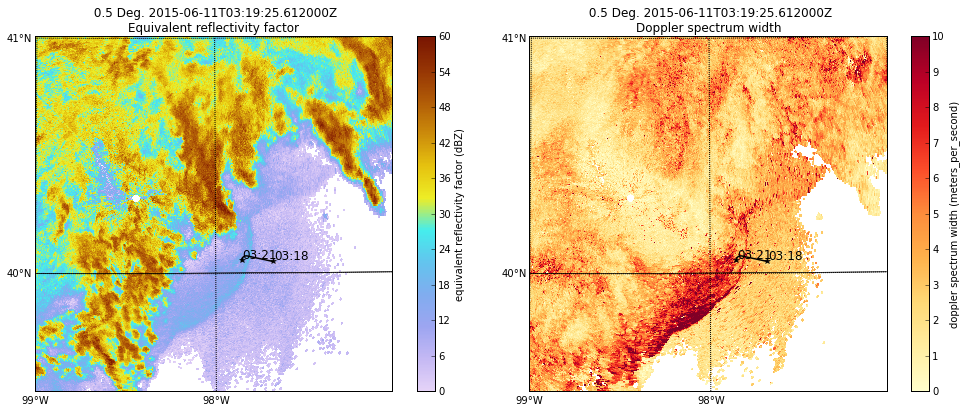

In [25]:
plot_list_of_fields_to_map(radar2, sweep=1, 
                    lonlim=[lonl[0], lonl[1]], latlim=[latl[0], latl[1]],
                    fields=['reflectivity', 'spectrum_width'],
                    vmins=[0, 0], vmaxs=[60, 10], 
                    units=['dBZ', 'm/s', 'm/s', 'EDR^0.33'],
                    cmaps=['pyart_LangRainbow12', 'YlOrRd'],
                    start_time=flight_squeeze[0], end_time=flight_squeeze[1],
                    plot_track=True, flight=flight1Hz,
                    plot_time_stamps=True, timestep=180,
                    savefig=True)

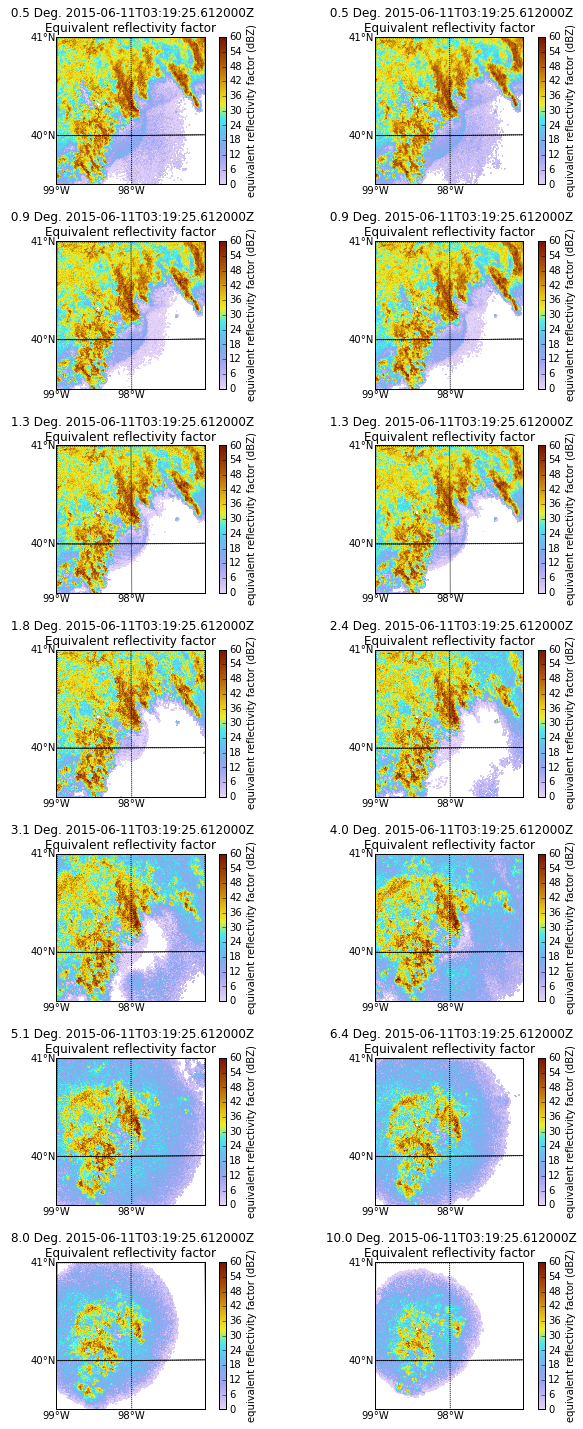

In [52]:
fig, axes = plt.subplots(7, 2, figsize=(9, 20))
mapdisplay = pyart.graph.RadarMapDisplay(radar2)

for nn, ax in enumerate(axes.flat):
#    display.plot_ppi('reflectivity', sweep=nn, vmin=0, vmax=60.,
#                    colorbar_label='dBZ', cmap='pyart_LangRainbow12', ax=ax)
#    display.set_limits(xlim=[-150, 150], ylim=[-150, 150], ax=ax)
    mapdisplay.plot_ppi_map('reflectivity', nn, vmin=0., vmax=60.,
                     min_lon=lonl[0], max_lon=lonl[1], 
                     min_lat=latl[0], max_lat=latl[1],
                     cmap='pyart_LangRainbow12', colorbar_flag=False,
                     projection='lcc', resolution='l',
                     lat_0=radar2.latitude['data'][0],
                     lon_0=radar2.longitude['data'][0], ax=ax)
    mapdisplay.plot_colorbar(ax=ax)
plt.tight_layout()
plt.savefig("KUEX_reflectivity_elevs_20150611031925.png")

Now let's look at sweep 5 that is closest to the aircraft

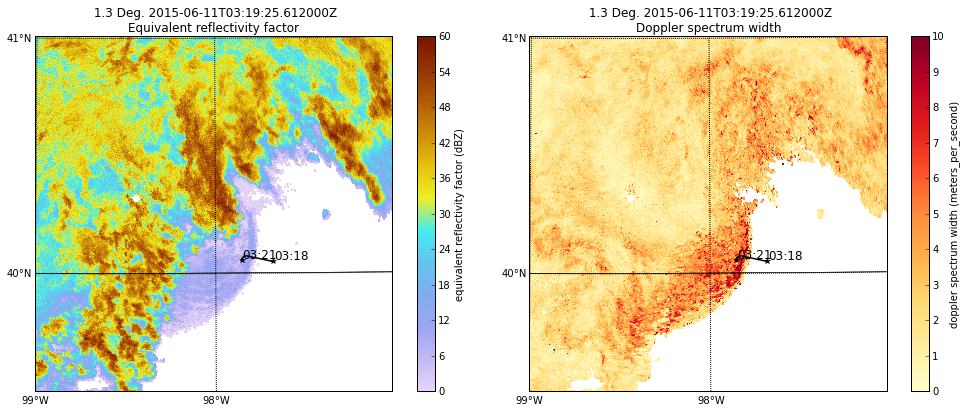

In [26]:
plot_list_of_fields_to_map(radar2, sweep=5, 
                    lonlim=[lonl[0], lonl[1]], latlim=[latl[0], latl[1]],
                    fields=['reflectivity', 'spectrum_width'],
                    vmins=[0, 0], vmaxs=[60, 10], 
                    units=['dBZ', 'm/s', 'm/s', 'EDR^0.33'],
                    cmaps=['pyart_LangRainbow12', 'YlOrRd'],
                    start_time=flight_squeeze[0], end_time=flight_squeeze[1],
                    plot_track=True, flight=flight1Hz,
                    plot_time_stamps=True, timestep=180,
                    savefig=True)

The next cell can be used to generate a larger individual image

In [ ]:
fig = plt.figure(figsize=(10.0, 10.))
display = pyart.graph.RadarMapDisplay(radar2)
#ax = fig.add_subplot(nrows, 2, index+1)
display.plot_ppi_map('turbulence', radsweep, vmin=0., vmax=1.,
            min_lon=lonl[0], max_lon=lonl[1], min_lat=latl[0], max_lat=latl[1],
            cmap='cubehelix',projection='aeqd', resolution='l',
            lat_0=radar2.latitude['data'][0], lon_0=radar2.longitude['data'][0])
f2 = FlightLevel(flight1Hz, basemap=display.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=flight_squeeze[0], end_time=flight_squeeze[1],)
f2.time_stamps(start_time=flight_squeeze[0], end_time=flight_squeeze[1],
                           labelspacing=120)